In [48]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from numba import jit, prange, njit
import networkx as nx
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from scipy import optimize, stats
import math

In [223]:
def init_pattern(N, min_value = 0, max_value = 100):
    '''
    Returns a continuous-valued pattern 
    
    INPUTs:
    -size of the pattern
    OUTPUTs:
    -pattern of size N
    '''
    pattern = np.random.uniform(1, 5, size = N)
    return pattern
# to do with gaussian distribution (standard)

In [224]:
a = init_pattern(10)
b = init_pattern(10)
print(a, "\n")
print(b)

[1.71606049 3.40900054 2.11393293 1.75120457 1.99930137 3.81034808
 2.53942523 2.01539191 1.97376417 1.56877474] 

[4.24286984 3.13150921 2.94127515 3.73698036 4.25226883 4.13549425
 2.50402425 2.70123955 3.66331562 4.49616287]


In [225]:
def overlap(pattern1, pattern2):
    return np.sum(pattern1 * pattern2)

In [226]:
overlap(a,b)

81.06427937727719

In [227]:
def multiple_patterns(n_patterns, pattern_size, min_value = 0, max_value = 100):
    '''
    Returns M binary patterns of size N
    
    Inputs:
    -M, the number of patterns
    -N, the size of each pattern
    
    Output:
    -A matrix containing one pattern per row
    '''
    a_c = 2**(pattern_size/2)
    
    if n_patterns <= math.floor(pattern_size*a_c):
        patterns = np.full((n_patterns, pattern_size), 0, dtype = np.float64)
        for j in prange(n_patterns): patterns[j] = init_pattern(pattern_size, min_value, max_value)
        return patterns
    else: print("Impossible to store all the patterns")

In [228]:
some_patterns = multiple_patterns(20, 10)
print(some_patterns.shape[0])

20


In [229]:
print(some_patterns, "\n")
print(some_patterns**2, "\n")
print(np.max(np.sum(some_patterns**2, axis = 1)))
print(np.max(np.sum(some_patterns**2, axis = 1)))

[[2.50687487 1.98169433 2.7157012  1.74253345 1.49535489 1.72698444
  3.15286141 1.5239273  3.08506654 3.51762352]
 [4.43315111 2.70310686 4.26563558 2.00372958 3.35333693 2.27059845
  2.4313343  3.00885566 2.63502115 2.56917337]
 [4.03399227 3.69466975 4.83726805 3.58410926 4.80367935 4.15210627
  2.92309599 2.13676273 4.89553518 3.27424595]
 [1.18479209 2.27469402 1.15859827 3.88291878 3.47802701 3.93289798
  2.71359564 3.42063848 1.32365803 4.16568043]
 [3.76181393 2.50266166 3.17242762 4.36341648 1.65565705 4.65796814
  1.23865627 1.69183293 2.16705464 3.35297722]
 [4.73378534 3.75836676 2.85814665 4.47874485 3.37117957 2.91565547
  2.70178852 2.61641935 3.46879708 3.96418533]
 [4.92728195 3.24754207 4.64191277 1.28017701 2.77207003 3.34856926
  4.46281864 2.38547708 4.88619119 2.51046361]
 [1.09337709 2.35494041 3.94497819 2.34628011 3.495643   1.10015078
  2.58746524 1.59871719 3.16879485 2.69592949]
 [1.15032477 4.85350419 1.52054929 4.65395109 2.2177434  2.47244192
  4.35425539

In [230]:
def energy(pattern, original_patterns, beta = 1, gamma = 1):
    
    M = original_patterns.shape[0]
    N = original_patterns.shape[1]
    
    max_norm_squared = np.max(np.sum(original_patterns**2, axis = 1))
    se = 0
    for mu in range(M):
        se += np.exp(beta * overlap(pattern, original_patterns[mu]) )
    lse = (1./beta) * np.log(se)
    
    energy = (-1.) * lse + 0.5 * gamma * np.sum(pattern * pattern) + (1./beta) * np.log(M) + 0.5 * max_norm_squared
    
    #print(2*max_norm_squared)
    if energy >= 10**4 : return 10**4
    else: return energy

In [231]:
print(energy(some_patterns[6], some_patterns))
casual = np.random.normal(size = N)
print(casual)
print(energy(casual, some_patterns))

10.686561182062249
[-1.38869258  0.8128587   0.10824147 -0.03766949 -1.39466838  1.08315313
 -0.71781174 -1.70488348  0.04262368 -0.27012827]
88.04647834754596


## Try to do the contour plot of the energy

Take three patterns $\vec{\xi}_{1}$, $\vec{\xi}_{2}$ and $\vec{\xi}_{3}$. Those three patterns are points in the d-dimensional space and thus they define a plane. The goal is to obtain other points on the same plane and compute the energy for each of them. A new pattern can be found as: $$ \vec{\xi}_{new} = \vec{\xi}_{1} + \alpha (\vec{\xi}_{2} - \vec{\xi}_{1}) + \beta (\vec{\xi}_{3} - \vec{\xi}_{1}),$$
where $$ 0 \leq \alpha, \beta \leq 1 $$

In [232]:
N = 10
##### define some patterns
some_patterns = multiple_patterns(20, 10)
##### take the first three patterns
p1, p2, p3 = some_patterns[0], some_patterns[1], some_patterns[2]

In [234]:
##### these 3 patterns define a plane. Now the goal is to obtain other patterns that belong to the same plane
alphas = np.linspace(-2, 2, 200)
betas  = np.linspace(-2, 2, 200)

L = len(alphas) * len(betas)
new_patterns = np.full( (L, N), 0)

X, Y = np.meshgrid(alphas, betas)

Z = np.full( (len(alphas), len(betas)), 0)

for i in range(len(alphas)):
    alpha = alphas[i]
    for j in range(len(betas)):
        new_pattern = p1 + alpha*(p2-p1) + betas[j]*(p3-p1)
        #print(alpha, betas[j])
        #print(energy(new_pattern, some_patterns), "\n")
        Z[i, j] = energy(new_pattern, some_patterns)

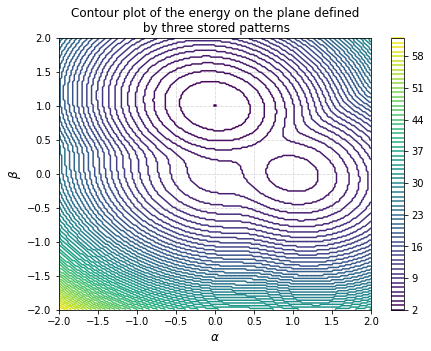

In [257]:
size = 12
fig = plt.figure(figsize = (7,5))
plt.contour(X, Y, Z, 60)
plt.xlabel(r"$\alpha$", size = size)
plt.ylabel(r"$\beta$", size = size)
plt.title("Contour plot of the energy on the plane defined\n by three stored patterns", size = size)
plt.colorbar()
plt.grid(axis = "both", linestyle = "--", alpha = 0.5)
fig.savefig("contour.pdf", transparent = True)

In [233]:
for m in range(20):
    print(energy(some_patterns[m], some_patterns))


a = np.random.normal(size = N)
print(energy(a, some_patterns))

7.327257007758263
2.9956934732779033
5.463647206077702
7.5569350232905705
18.104636543185222
13.47881371611794
18.241440419332896
15.325740434914543
10.794770106989958
16.821804789818664
8.099555672975654
21.07125488557527
13.293202183696259
12.570163210063143
13.83034434699993
5.06742068722081
12.197886887521939
11.698777579765434
11.704825592652519
8.061854769144794
49.45186037206773


Text(0.5, 0, 'z')

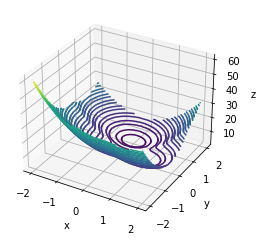

In [258]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [260]:
##### these 3 patterns define a plane. Now the goal is to obtain other patterns that belong to the same plane
alphas = np.linspace(0, 1, 100)
betas  = np.linspace(0, 1, 100)

L = len(alphas) * len(betas)
new_patterns = np.full( (L, N), 0)

X, Y = np.meshgrid(alphas, betas)

Z = np.full( (len(alphas), len(betas)), 0)

for i in range(len(alphas)):
    alpha = alphas[i]
    for j in range(len(betas)):
        new_pattern = p1 + alpha*(p2-p1) + betas[j]*(p3-p1)
        #print(alpha, betas[j])
        #print(energy(new_pattern, some_patterns), "\n")
        Z[i, j] = energy(new_pattern, some_patterns)

Text(0, 0.5, '$\\beta$')

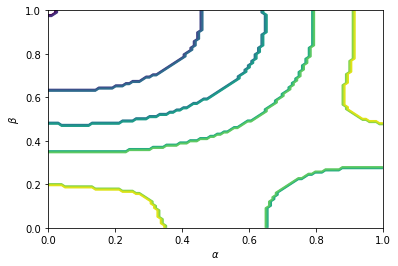

In [263]:
plt.contour(X, Y, Z, 20)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")

In [87]:
prova = p1 + (-10)*(p2-p1) + (-10)*(p3-p1)
prova

array([  446.45197212,   176.97096201, -1222.87809944,    -9.95617576,
         -98.98907923,   157.19194112,  1030.83204672,  -469.98124084,
         955.86756826,   330.42523825])

In [91]:
energy(prova, some_patterns, lam = 0.0000001)

-30043756.015540153

In [135]:
energy(p1, some_patterns, lam = 0.0000001)

-29980662.610942148